In [1]:
import tensorflow as tf

using_gpu_index = 0 # 使用的 GPU 号码
gpu_list = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(
        gpu_list[using_gpu_index],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 4.75)]
    )


2023-10-16 23:52:15.138787: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-16 23:52:15.145774: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-16 23:52:15.145981: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
from models.quantum_models import generate_model_policy
import cirq

import models.quantum_genotypes as genotypes
env_name = "Acrobot-v1"

genotype = genotypes.ORI_TYPE_AB

n_qubits = 6 # Dimension of the state vectors in CartPole
# n_layers = 5 # Number of layers in the PQC
n_actions = 3 # Number of actions in CartPole

qubits = cirq.GridQubit.rect(1, n_qubits)
observables = [cirq.Z(qubits[0]), cirq.Z(qubits[1]), cirq.Z(qubits[2]), cirq.Z(qubits[3]), cirq.Z(qubits[4]), cirq.Z(qubits[5])] # Z_0*Z_1*Z_2*Z_3


# generate_model_policy(qubits, genotype, n_actions, beta, observables, env):
model = generate_model_policy(qubits, genotype, n_actions, 1., observables, env_name)

2023-10-16 23:52:15.960867: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 23:52:15.961947: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-16 23:52:15.962192: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-16 23:52:15.962314: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Acrobot-v1


In [3]:
from models.quantum_models import generate_circuit
from IPython.display import display, HTML
circuit, params, inputs = generate_circuit(qubits, genotype)
display(HTML(f"<pre>{circuit}</pre>"))

In [4]:
def normalized_state(s, ub, lb):
    return -1 + 2 * (s - lb) / (ub - lb)

In [5]:
import gym
from collections import defaultdict
import tensorflow as tf
import numpy as np


def gather_episodes(state_ub, state_lb, n_actions, model, n_episodes, env_name):
    """Interact with environment in batched fashion."""

    trajectories = [defaultdict(list) for _ in range(n_episodes)]
    envs = [gym.make(env_name) for _ in range(n_episodes)]

    done = [False for _ in range(n_episodes)]
    # states = [e.reset() for e in envs]
    states = [e.reset()[0] for e in envs]


    while not all(done):
        unfinished_ids = [i for i in range(n_episodes) if not done[i]]
        # normalized_states = [s / state_bounds for i, s in enumerate(states) if not done[i]]
        normalized_states = [normalized_state(s, ub=state_ub, lb=state_lb) for i, s in enumerate(states) if not done[i]]

        for i, state in zip(unfinished_ids, normalized_states):
            trajectories[i]['states'].append(state)

        # Compute policy for all unfinished envs in parallel
        states = tf.convert_to_tensor(normalized_states)
        action_probs = model([states])

        # Store action and transition all environments to the next state
        states = [None for i in range(n_episodes)]
        for i, policy in zip(unfinished_ids, action_probs.numpy()):
            action = np.random.choice(n_actions, p=policy)
            # 
            states[i], reward, terminated, truncated, _ = envs[i].step(action)
            done[i] = terminated or truncated
            trajectories[i]['actions'].append(action)
            trajectories[i]['rewards'].append(reward)

    return trajectories

In [6]:
def compute_returns(rewards_history, gamma):
    """Compute discounted returns with discount factor `gamma`."""
    returns = []
    discounted_sum = 0
    for r in rewards_history[::-1]:
        discounted_sum = r + gamma * discounted_sum
        returns.insert(0, discounted_sum)

    # Normalize them for faster and more stable learning
    returns = np.array(returns)
    returns = (returns - np.mean(returns)) / (np.std(returns) + 1e-8)
    returns = returns.tolist()

    return returns

In [7]:
state_bounds = np.array([1., 1., 1., 1., 12.567 , 28.274])
state_ub = state_bounds
state_lb = -1 * state_bounds

In [8]:
gamma = 1
batch_size = 10
n_episodes = 2000
optimizer_in = tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True)
optimizer_var = tf.keras.optimizers.Adam(learning_rate=0.01, amsgrad=True)
optimizer_out = tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True)

# Assign the model parameters to each optimizer
w_in, w_var, w_out = 1, 0, 2

In [9]:
@tf.function
def reinforce_update(states, actions, returns, model):
    states = tf.convert_to_tensor(states)
    actions = tf.convert_to_tensor(actions)
    returns = tf.convert_to_tensor(returns)

    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        logits = model(states)
        p_actions = tf.gather_nd(logits, actions)
        log_probs = tf.math.log(p_actions)
        loss = tf.math.reduce_sum(-log_probs * returns) / batch_size
    grads = tape.gradient(loss, model.trainable_variables)
    for optimizer, w in zip([optimizer_in, optimizer_var, optimizer_out], [w_in, w_var, w_out]):
        optimizer.apply_gradients([(grads[w], model.trainable_variables[w])])

In [10]:
def features(episode):
    obs = np.clip(episode['states'], -10, 10)  # 找出所有state 
    length = len(episode['states'])  # 长度
    al = np.arange(length).reshape(-1, 1) / 100.0  # 
    return np.concatenate(
        [obs, obs ** 2, al, al ** 2, al ** 3,
         np.ones((length, 1))], axis=1)

In [11]:
# model.load_weights('./weights_MC.h5')
import os
from datetime import datetime
start_time = datetime.now()

env_name = "Acrobot-v1"
best_avg_rewards = -600
avg_rewards = -600
times = 0
while(avg_rewards < -150):
    # if os.path.exists('./weights_AB.h5'):
    #     # print(times := times + 1)
    #     model.load_weights('./weights_AB.h5')

    # Start training the agent
    episode_reward_history = []
    for batch in range(n_episodes // batch_size):
        # Gather episodes
        episodes = gather_episodes(state_ub, state_lb, n_actions, model, batch_size, env_name)

        # Group states, actions and returns in numpy arrays
        states = np.concatenate([ep['states'] for ep in episodes])
        actions = np.concatenate([ep['actions'] for ep in episodes])
        rewards = [ep['rewards'] for ep in episodes]
        returns = np.concatenate([compute_returns(ep_rwds, gamma) for ep_rwds in rewards])
        returns = np.array(returns, dtype=np.float32)

        id_action_pairs = np.array([[i, a] for i, a in enumerate(actions)])
        
        
        # baseline 部分
        coeffs = None
        featmat = np.concatenate([features(episode) for episode in episodes])
        # rewards = [ep['rewards'] for ep in episodes]
        # returns = np.concatenate([compute_returns(ep_rwds, gamma) for ep_rwds in rewards])
        # returns = np.array(returns, dtype=np.float32)
        reg_coeff = 1e-5
        """
            Linear baseline based on handcrafted features, as described in [1]
            (Supplementary Material 2).
        
            [1] Yan Duan, Xi Chen, Rein Houthooft, John Schulman, Pieter Abbeel,
                "Benchmarking Deep Reinforcement Learning for Continuous Control", 2016
                (https://arxiv.org/abs/1604.06778)
                
            # https://github.com/rlworkgroup/garage/tree/master/src/garage/np/baselines
        """
        
        
        
        
        for _ in range(5):  # 似乎就是尝试拟合出来一个东西
            coeffs = np.linalg.lstsq(
                featmat.T.dot(featmat) +
                reg_coeff * np.identity(featmat.shape[1]),
                featmat.T.dot(returns),
                rcond=-1)[0]
            if not np.any(np.isnan(coeffs)):
                break
            reg_coeff *= 10
            
        bs = np.concatenate([features(episode).dot(coeffs) if coeffs is not None else np.zeros(len(rewards)) for episode in episodes])
        
        returns = np.array(returns - bs, dtype=np.float32)
        
        

        # Update model parameters.
        reinforce_update(states, id_action_pairs, returns, model)

        # Store collected rewards
        for ep_rwds in rewards:
            episode_reward_history.append(np.sum(ep_rwds))

        avg_rewards = np.mean(episode_reward_history[-10:])

        print('Finished episode', (batch + 1) * batch_size,
              'Average rewards: ', avg_rewards)

        # model.save_weights('./weights_MC.h5')

        if avg_rewards >= best_avg_rewards:
            best_avg_rewards = avg_rewards
            # model.save_weights('./weights_AB.h5')

        if avg_rewards >= -150:
            break

end_time = datetime.now()
elapsed_time = end_time - start_time

print(f"代码执行时间：{elapsed_time}")

Finished episode 10 Average rewards:  -498.8
Finished episode 20 Average rewards:  -500.0
Finished episode 30 Average rewards:  -500.0
Finished episode 40 Average rewards:  -500.0
Finished episode 50 Average rewards:  -500.0
Finished episode 60 Average rewards:  -500.0
Finished episode 70 Average rewards:  -487.6
Finished episode 80 Average rewards:  -500.0
Finished episode 90 Average rewards:  -476.1
Finished episode 100 Average rewards:  -483.8
Finished episode 110 Average rewards:  -461.9
Finished episode 120 Average rewards:  -430.6
Finished episode 130 Average rewards:  -385.6
Finished episode 140 Average rewards:  -358.6
Finished episode 150 Average rewards:  -307.0
Finished episode 160 Average rewards:  -289.7
Finished episode 170 Average rewards:  -231.7
Finished episode 180 Average rewards:  -218.7
Finished episode 190 Average rewards:  -215.1
Finished episode 200 Average rewards:  -165.8
Finished episode 210 Average rewards:  -180.8
Finished episode 220 Average rewards:  -157

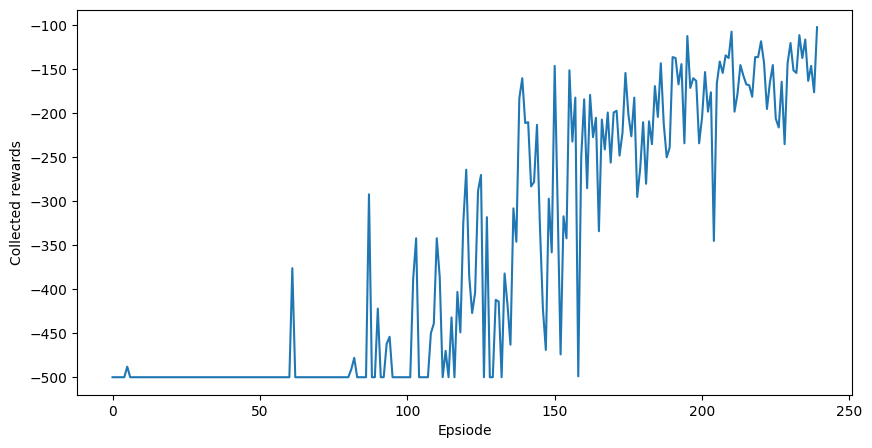

In [14]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(episode_reward_history)
plt.xlabel('Epsiode')
plt.ylabel('Collected rewards')
plt.show()

In [15]:
import pandas as pd

# 创建一个DataFrame对象
df = pd.DataFrame({'episode_reward_history': episode_reward_history})

# 将DataFrame保存到CSV文件
df.to_csv('../../results/example/PG/AB_episode_reward_history', index=False)  # 可以指定文件名和是否包括行索引
model.save_weights('../../weights/example/PG/PG_AB_weights.h5')